X_vectorized.shape: (1756, 51)
X_vectorized array length: 1756
X_transformed.shape: (1756, 52)
X_vectorized.shape: (1172, 51)
X_vectorized array length: 1172
X_transformed.shape: (1172, 52)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


/home/joao_leitao_ubuntu/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 160 is smaller than n_iter=512. Running 160 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


cv_results_ :  {'mean_fit_time': array([0.11720276, 0.22834496, 0.12823219, 0.13109727, 0.08809848,
       0.16985693, 0.10357575, 0.14417415, 0.0747735 , 0.20840459,
       0.26231933, 0.29217858, 0.18141894, 0.30204558, 0.25807548,
       0.14666157, 0.07158308, 0.12362075, 0.11809249, 0.1044692 ,
       0.04979696, 0.14778218, 0.12093892, 0.14082336, 0.09332728,
       0.14922514, 0.12673988, 0.14036922, 0.08657966, 0.20028892,
       0.18188734, 0.21803536, 0.14003744, 0.35558529, 0.23048849,
       0.24678493, 0.16855841, 0.33859835, 0.25835733, 0.22954316,
       0.14381442, 0.2458077 , 0.22680287, 0.24316764, 0.08418832,
       0.22022099, 0.23755951, 0.2524106 , 0.16641078, 0.26174703,
       0.26422429, 0.27860093, 0.27555523, 0.30993872, 0.2613965 ,
       0.22793093, 0.18097439, 0.25860796, 0.24472051, 0.25312119,
       0.15354228, 0.21075888, 0.19622011, 0.24808264, 0.19673905,
       0.31214557, 0.39204364, 0.46137409, 0.190657  , 0.27249455,
       0.28142581, 0.43674903

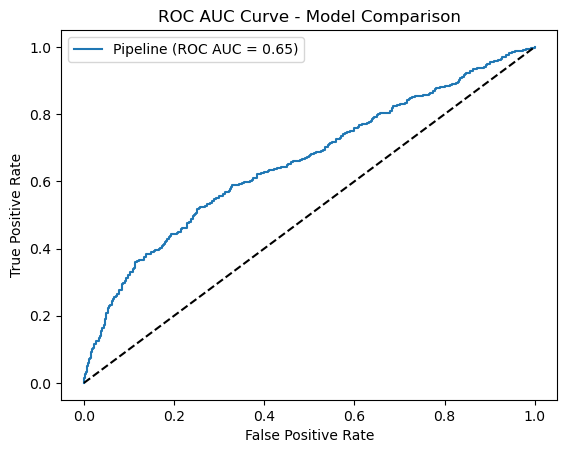

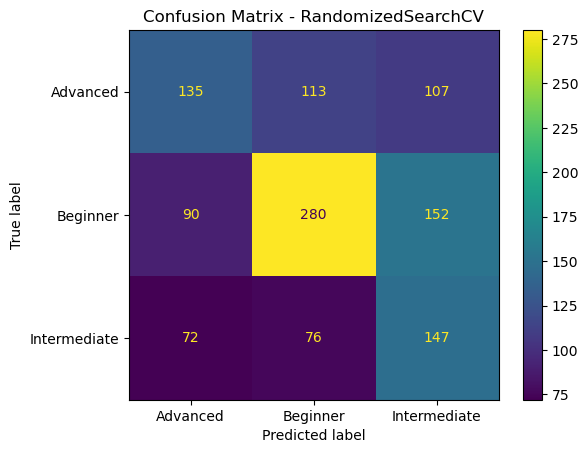


The tunning of LogistcRegression process took: 
	38.210689306259155 seconds 

Finished writing file


In [1]:
import time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
)
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


start = time.time()


def getDataframeXyAndLabelEncoder(data):
    # Convert data into a dataframe
    df = pd.DataFrame(data)

    # Encode the "University" column into numerical values
    label_encoder = LabelEncoder()
    df["University"] = label_encoder.fit_transform(df["University"])

    # Create a separate dataframe for the "University" column
    df_university = pd.DataFrame(df["University"])

    # Generate a new dataset by merging three columns
    X = df["Course_Name"] + " " + df["Course_Description"] + " " + df["Skills"]
    X = pd.DataFrame(X)
    X = X.rename(columns={0: "Name_Description_Skills"})

    # Vectorize the text data using CountVectorizer
    count_vect = CountVectorizer(max_features=51, ngram_range=(1, 2), lowercase=True)
    X_vectorized = count_vect.fit_transform(X["Name_Description_Skills"])

    # Print the shape of the vectorized data
    print("X_vectorized.shape:", X_vectorized.shape)
    print("X_vectorized array length:", len(X_vectorized.toarray()))

    # Convert the vectorized data into a dataframe
    X_vectorized_array = X_vectorized.toarray()
    X_vectorized_df = pd.DataFrame(X_vectorized_array)

    # Rename columns of the dataframe created from CountVectorizer
    X_vectorized_df.columns = X_vectorized_df.columns.astype(str)

    # Add the "University" column back to the dataframe
    X_vectorized_df.insert(0, "University", df_university, True)

    X_transformed = X_vectorized_df

    # Print the shape of the transformed data
    print("X_transformed.shape:", X_transformed.shape)

    # Encode the target labels to numerical values
    label_encoder = LabelEncoder()
    df["Difficulty_Level_Encoded"] = label_encoder.fit_transform(df["Difficulty_Level"])
    y_encoded = df["Difficulty_Level_Encoded"]

    return X_transformed, y_encoded, label_encoder


# read the data from storage
data_from_train_dataset = pd.read_csv("train.csv", sep=";", encoding="latin-1")

# prepare data
X_train_transformed, y_train, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_train_dataset
)

# read the data from storage
data_from_test_dataset = pd.read_csv("test.csv", sep=";", encoding="latin-1")

# prepare data
X_test_transformed, y_test, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_test_dataset
)

# Define the parameter grid for LogisticRegression

param_grid = {
    # Maximum number of iterations taken for the solvers to converge.
    "max_iter": [120, 220, 420, 720],  # range of params for testing
    # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    # Adjust the intercept fitting
    "fit_intercept": [True, False],  # range of params for testing
    # Adjust the multi-class strategy
    "multi_class": ["ovr"],
    # not used elasticnet because lbfgs and newton-cg use just l2
    # 'elasticnet': both L1 and L2 penalty terms are added.
    # Adjust the regularization penalty
    "penalty": ["l2"],
    # Dont used "newton-cholensky" because the memory consumption and other reasons that are in docs
    # Adjust the solver algorithm
    "solver": [
        "lbfgs",
        "newton-cg",
        "sag",
        "saga",
    ],  # range of params for testing
    # # Number of jobs to run in parallel (-1 means using all processors)
    "n_jobs": [-1],
    # disabled cause was crashing the notebook execution
    # "verbose": [1],  # Enable verbose output
    # # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    "class_weight": ["balanced"],
    # Adjust the regularization parameter C
    "C": [0.001, 0.01, 0.1, 1, 10],  # range of params for testing
}


# used LogisticRegression and not LogisticRegressionCV because the cross-validation will be done in gridSearchCV https://stackoverflow.com/questions/46507606/what-does-the-cv-stand-for-in-sklearn-linear-model-logisticregressioncv
clf = LogisticRegression()

# to avoid data leakage across folds, perform all the steps of pipeline in each fold
# Create a pipeline with SMOTE oversampling, scaling, and the classifier
pipe = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", clf),
    ]
)


scoring = {
    # The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall
    # f_beta allows to choose a customized beta score, f1_score dont. If I try to pass beta parameter to f1_score, I get the error "f1_score() got an unexpected keyword argument "beta""
    # f1_score: The relative contribution of precision and recall to the F1 score are equal https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # "f1": make_scorer(f_beta_score, average="weighted", beta=1),
    "f1": make_scorer(f1_score, average="weighted"),
}

# Perform cross-validation for each model using the same folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Otimized to f1 score only
# Perform grid search to find the best parameters
""" searchCV = GridSearchCV(
    clf,
    param_grid,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    verbose=1,
) """

# RandomizedSearchCV chosen instead of GridSearchCV because of resources cost (prossessing time)
# Perform RandomizedSearchCV to find the best parameters
searchCV = RandomizedSearchCV(
    clf,
    param_grid,
    n_iter=512,
    scoring=scoring["f1"],
    refit="f1",
    cv=skf,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

# Create a pipeline with SMOTE oversampling, scaling, and the RandomizedSearchCV
pipe_SearchCV = Pipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        ("standardscaler", StandardScaler()),
        ("model", searchCV),
    ]
)

pipe_SearchCV.fit(X_train_transformed, y_train)

# Retrieve the results of the RandomizedSearchCV
results = searchCV.cv_results_
print("cv_results_ : ", results)
print("Best Parameters:", searchCV.best_params_)
print("Best F1 Score:", searchCV.best_score_)

# Evaluate the model on the test set
y_pred = pipe_SearchCV.predict(X_test_transformed)
report = classification_report(y_test, y_pred)
print("Classification report: ", report)


def plotRocAucCurve():
    # Get the predicted probabilities for each class on the test set
    y_scores = pipe_SearchCV.predict_proba(X_test_transformed)
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_scores, multi_class="ovr")
    print("\t \t ROC AUC score: ", roc_auc, "\n")

    # Set plot title and labels

    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)

    plt.plot(
        fpr,
        tpr,
        label="{} (ROC AUC = {:.2f})".format(pipe_SearchCV.__class__.__name__, roc_auc),
    )

    plt.title("ROC AUC Curve - Model Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], "k--")
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
    return roc_auc


roc_auc_result = plotRocAucCurve()


def plotConfusionMatrix(y_test, y_pred):
    # Calculate and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot the confusion matrix for each model
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot()
    plt.title(f"Confusion Matrix - {searchCV.__class__.__name__}")
    plt.show()
    return cm


confusion_matrix_result = plotConfusionMatrix(y_test, y_pred)


end = time.time()

# # # # # # # # print("RESULTS GridSearchCV \n".join(map(str, results)))

file_path = "results_tunning_LogisticRegression.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Write the contents of results array to the file
    file.write("best_params: \n")
    file.write("\t" + str(searchCV.best_params_))
    file.write("\n\n")
    file.write("best_score_: \n")
    file.write("\t" + str(searchCV.best_score_))
    file.write("\n\n")
    file.write("Classification report: \n")
    file.write(report)
    file.write("\n\n")
    file.write("ROC AUC score: \n")
    file.write("\t" + str(roc_auc_result))
    file.write("\n\n")
    file.write("Confusion matrix: \n")
    file.write("\t" + str(confusion_matrix_result[0]) + "\n")
    file.write("\t" + str(confusion_matrix_result[1]) + "\n")
    file.write("\t" + str(confusion_matrix_result[2]))
    file.write("\n\n")
    time_elapsed = str(end - start)
    message = (
        "\nThe tunning of LogistcRegression process took: \n"
        + "\t"
        + time_elapsed
        + " seconds \n"
    )
    file.write(message)
    file.write("\ncv_results: \n")
    file.write(str(searchCV.cv_results_))

print(
    "\nThe tunning of LogistcRegression process took: \n"
    + "\t"
    + time_elapsed
    + " seconds \n"
)
print("Finished writing file")